In [12]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ocf_blosc2 as Blosc2
import xarray as xr
import pandas as pd
import h5py

# visualize baked entries

In [3]:
baked2020 = np.load('../baked_nonhrv_2020_v2.npy')
baked2021 = np.load('../baked_nonhrv_2021_v2.npy')

In [4]:
dates2020 = [datetime.strptime(str(b[0]), '%y%m%d%H%M') for b in baked2020]
dates2021 = [datetime.strptime(str(b[0]), '%y%m%d%H%M') for b in baked2021]

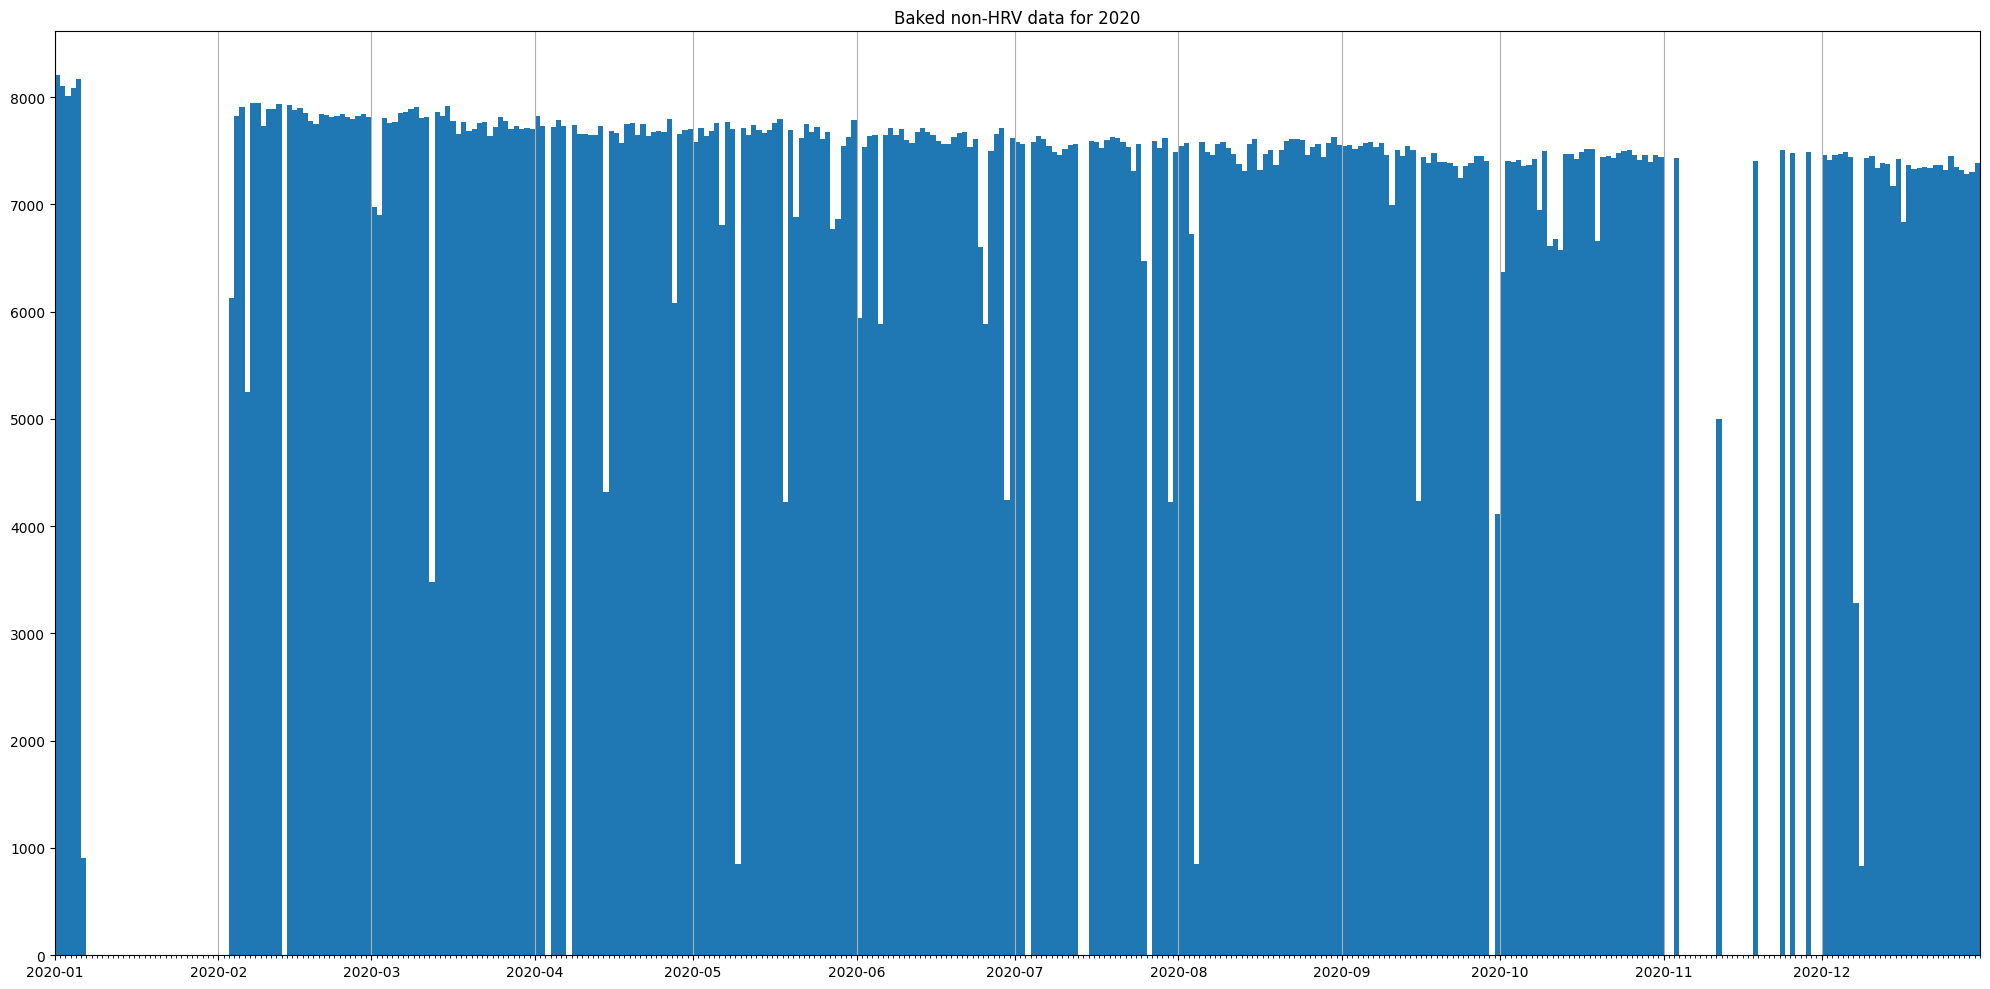

In [23]:
plt.figure(figsize=(20, 10))
plt.title('Baked non-HRV data for 2020')
plt.hist(dates2020, bins=[datetime(2020, 1, 1) + i * timedelta(days=1) for i in range(366)])
# put minor ticks at the days and major ticks at the months
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid(which='major', axis='x')
plt.xlim(datetime(2020, 1, 1), datetime(2020, 12, 31))
plt.tight_layout()

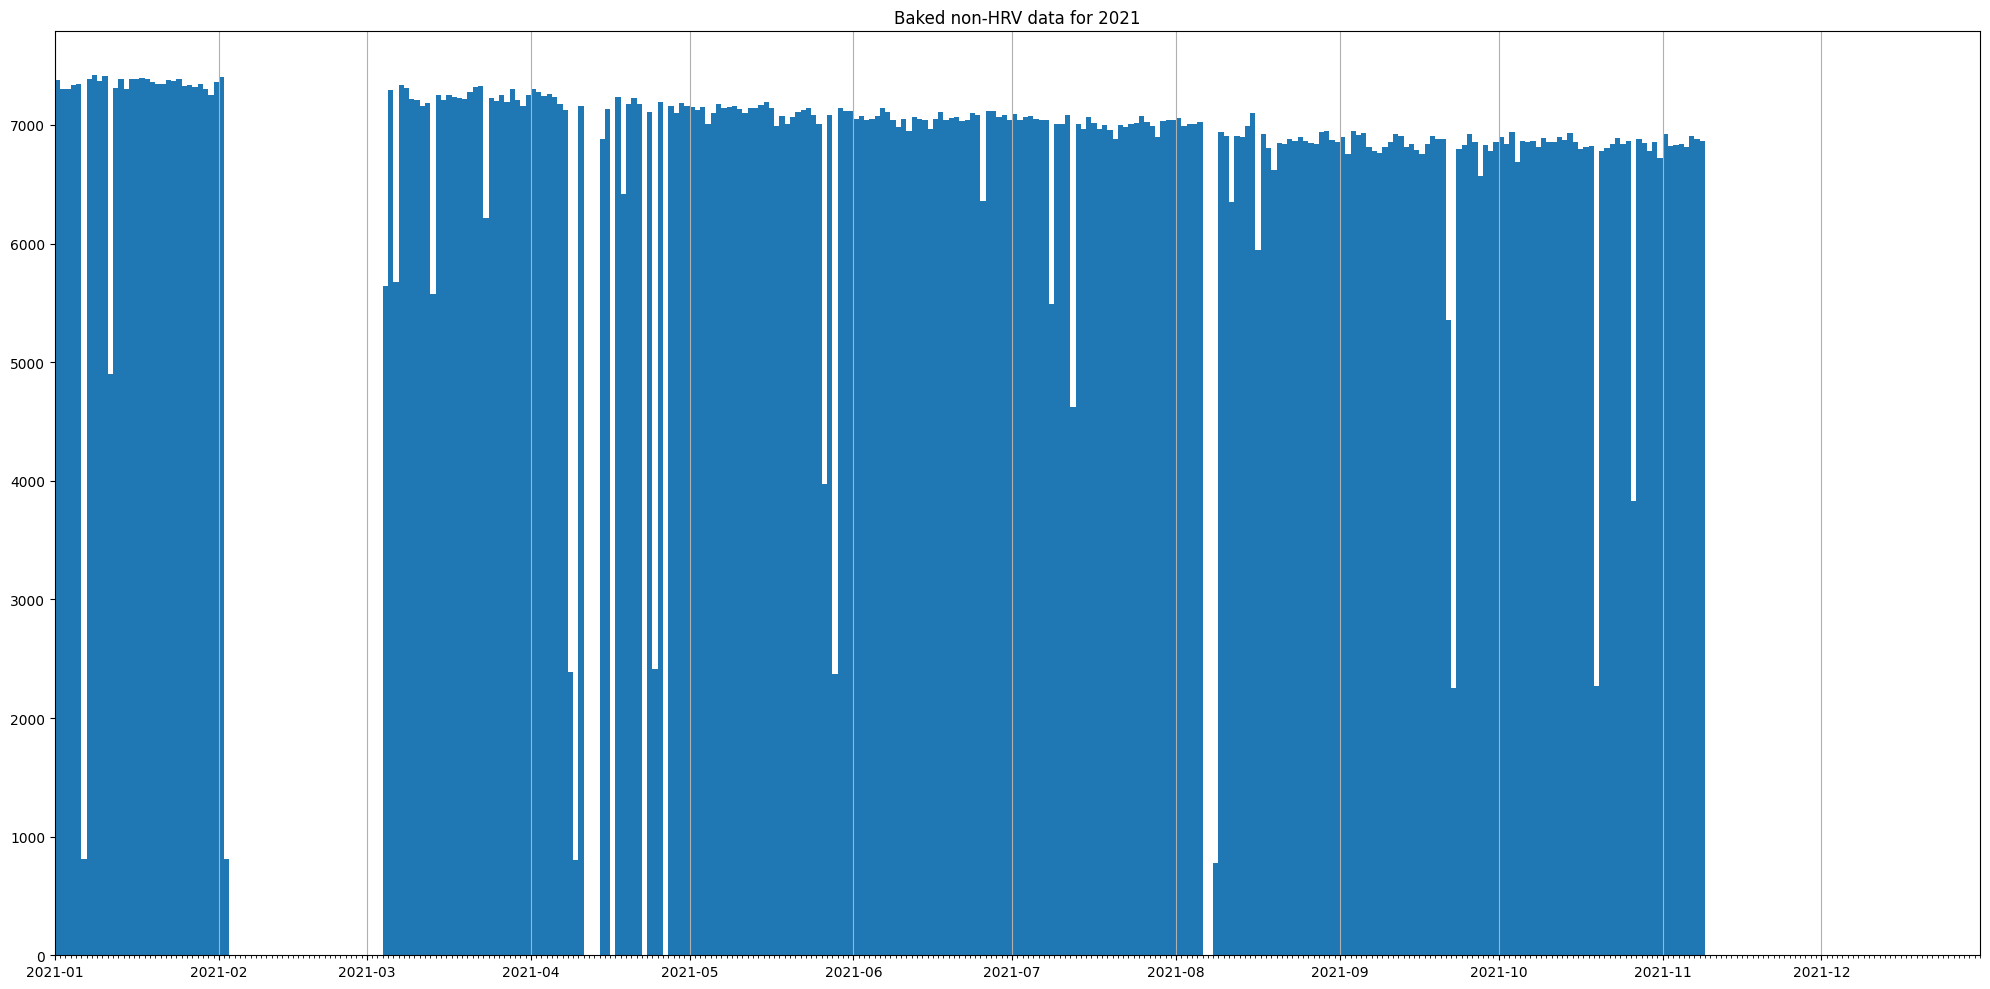

In [24]:
plt.figure(figsize=(20, 10))
plt.title('Baked non-HRV data for 2021')
plt.hist(dates2021, bins=[datetime(2021, 1, 1) + i * timedelta(days=1) for i in range(365)])
# put minor ticks at the days and major ticks at the months
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid(which='major', axis='x')
plt.xlim([datetime(2021, 1, 1), datetime(2021, 12, 31)])
plt.tight_layout()

# Bake PV, nonhrv, and weather data

In [9]:
# get all hours for which we need to bake data (ie all hours in baked + 4 hours in each gap)
times = set()
for timeint, site in baked2020:
    time = datetime.strptime(str(timeint), '%y%m%d%H%M')
    times.add(time)
    # for i in range(1, 5):
    #     times.add(time + timedelta(hours=i))
for timeint, site in baked2021:
    time = datetime.strptime(str(timeint), '%y%m%d%H%M')
    times.add(time)
    # for i in range(1, 5):
    #     times.add(time + timedelta(hours=i))

n_times = len(times)
nonhrv_times = sorted(list(times))
n_times

5072

In [10]:
pv = pd.concat([
        pd.read_parquet(f"/data/climatehack/official_dataset/pv/{y}/{m}.parquet").drop("generation_wh", axis=1)
        for y in (2020, 2021)
        for m in range(1, 13)
])

nonhrv = xr.open_mfdataset(
        f"/data/climatehack/official_dataset/nonhrv/*/*.zarr.zip",
        engine="zarr",
        chunks="auto"
)

weather = xr.open_mfdataset(
        f"/data/climatehack/official_dataset/weather/*/*.zarr.zip",
        engine="zarr",
        chunks="auto"
)

In [11]:
import h5py
from tqdm import tqdm

In [14]:
h5file = h5py.File("data.h5", "w")
ds = h5file.create_dataset("nonhrv", shape=(n_times, 12, 293, 333, 11), dtype=np.float16, chunks=(1, 12, 32, 32, 11))

for i, time in enumerate(tqdm(times)):
    ds[i] = nonhrv['data'].sel(time=slice(time, time + timedelta(minutes=55))).to_numpy()

h5file.close()

100%|██████████| 5072/5072 [06:28<00:00, 13.04it/s]


In [20]:
nonhrv['data'].sel(time=slice(time, time + timedelta(minutes=55)))

<xarray.DataArray 'data' (time: 0, y_geostationary: 293, x_geostationary: 333,
                          channel: 11)>
dask.array<getitem, shape=(0, 293, 333, 11), dtype=float16, chunksize=(0, 293, 333, 11), chunktype=numpy.ndarray>
Coordinates:
  * channel          (channel) <U6 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * time             (time) datetime64[ns] 
  * x_geostationary  (x_geostationary) float64 -2.52e+05 ... -1.248e+06
  * y_geostationary  (y_geostationary) float64 4.303e+06 4.306e+06 ... 5.179e+06
Attributes: (12/204)
    IR_016__satpy_id:                              !!python/object/apply:satp...
    IR_016_ancillary_variables:                    []
    IR_016_area:                                   msg_seviri_rss_3km:\n  des...
    IR_016_calibration:                            reflectance
    IR_016_end_time:                               2020-01-01T00:00:07.676580
    IR_016_georef_offset_corrected:                True
    ...                                            ...
    orbital_parameters:                            projection_altitude: 35785...
    platform_name:                                 Meteosat-10
    reader:                                        seviri_l1b_native
    resolution:                                    3000.403165817
    sensor:                                        seviri
    start_time:                                    2019-12-31T23:55:07.772388

In [18]:
nonhrv_times_map = {t:i for i, t in enumerate(nonhrv_times)}

In [19]:
import pickle
with open("nonhrv_times_map.pkl", "wb") as f:
    pickle.dump(nonhrv_times_map, f)

In [20]:
import numpy as np
a = np.zeros((10,), dtype=[('a', np.uint32), ('b', np.uint32), ('c', np.bool_, (10,))])
a

array([(0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False]),
       (0, 0, [False, False, False, False, False, False, False, False, False, False])],
      dtype=[('a', '<u4'), ('b', '<u4'), ('c', '?', (10,))])

In [22]:
a['c'].any(axis=1)

array([False, False, False, False, False, False, False, False, False,
       False])

# Final bake

In [22]:
bake_index = np.load('../bake_index.npy')
bake_index

array([(1577865600,  2607, [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True], [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True]),
       (1577865600,  2626, [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True], [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True]),
       (1577865600,  2631, [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True], [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  Tr

In [27]:
dt = np.dtype([
     ('time', np.int32),
     ('site', np.int32),
     ('nonhrv_flags', np.bool_, (11,)),
     ('weather_flags', np.bool_, (38,)),
 ], align=True)
bake_index = bake_index.astype(dt)

In [28]:
np.save('../bake_index.npy', bake_index)

In [23]:
%%timeit
bake_index[237855]

80.6 ns ± 10.6 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [24]:
data = h5py.File("../data.h5", "r")
data.keys()

<KeysViewHDF5 ['nonhrv', 'weather']>

In [25]:
data['nonhrv'].chunks

(1, 12, 32, 32, 1)

In [21]:
data['weather'].attrs['times'].shape

(431,)

# int8 conversion

In [1]:
import numpy as np

nonhrv_min = np.array([0.0209, 0.1356, 0., 0., 0., 0.03937, 0.0682, 0.002346, 0.013504, 0., 0.])
nonhrv_max = np.array([1., 0.975, 0.899, 0.866, 1., 0.9917, 1., 1., 1., 1., 0.7856])
weather_min = np.array([
  2.590e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
  0.000e+00,  0.000e+00,  0.000e+00, -1.032e+01, -4.028e+01, -3.334e+01,
 -1.677e+01,     np.inf,  3.576e+00, -2.157e-01, -1.979e-05,  2.489e+02,
  2.284e+02,  2.505e+02,  2.541e+02,  2.358e+02,  2.335e+02,  0.000e+00,
 -2.722e+01, -2.866e+01, -4.912e+01, -4.631e+01, -3.747e+01, -2.695e+01,
 -5.691e+01, -5.909e+01, -3.709e+01, -3.981e+01,  5.722e-02,  0.000e+00,
  0.000e+00,  2.950e-05])
weather_max = np.array([
 8.5000e+01, 5.4450e+02, 8.6400e+02, 2.2440e+03, 1.0000e+02, 1.0000e+02,
 1.0000e+02, 1.0000e+02, 4.3086e+00, 1.3172e+01, 2.6891e+01, 2.2797e+01,
 1.4117e+01,     np.inf, 1.0000e+02, 1.5375e+02, 1.2394e+02, 3.1375e+02,
 2.6975e+02, 2.9975e+02, 3.0950e+02, 3.2250e+02, 2.9775e+02, 1.5075e+02,
 2.9094e+01, 7.3375e+01, 7.9500e+01, 4.7188e+01, 3.9812e+01, 2.8469e+01,
 5.1812e+01, 6.0844e+01, 4.8625e+01, 4.2469e+01, 6.5062e+01, 1.4220e+03,
 9.6000e+01, 1.0000e+00])